In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Import data

In [2]:
path_to_data = "C:/Users/vince/Documents/DataChallengeJFR/liver/data/"

In [3]:
df = pd.read_csv(path_to_data + "foie_train_set.csv")
df = df.set_index("id")
n_data = df.shape[0]

dict_lesion = {"Kyste":0,"Angiome":1, "CHC":2, "Foie Homogene":3, "HNF":4, "Metastase":5}
dict_class_nber = {"class_nber": []}
for id_liver in df.index:
    dict_class_nber["class_nber"].append(dict_lesion[df.loc[id_liver,"Type de lesion"]])
df["class_nber"] = pd.DataFrame(dict_class_nber, index = df.index)

print("Number of echos: {}".format(n_data))
print(df["Type de lesion"].value_counts())
print(df.head())

Number of echos: 367
Foie Homogene    258
Metastase         48
Kyste             30
Angiome           17
HNF                8
CHC                6
Name: Type de lesion, dtype: int64
         Benin  Lesion  Malin Type de lesion  class_nber
id                                                      
foie_1       0       0      0  Foie Homogene           3
foie_5       0       0      0  Foie Homogene           3
foie_9       0       0      0  Foie Homogene           3
foie_11      0       0      0  Foie Homogene           3
foie_12      0       0      0  Foie Homogene           3


# Data pre-procesing

In [4]:
for f in df.index :
    im = Image.open(path_to_data + "raw_data/" + f + ".bmp")
    im = im.resize((960,720), PIL.Image.BICUBIC)
    array_one = np.array(im)
    array_one = np.expand_dims(array_one, axis=0)
    if f == "foie_1":
        array_all = array_one
    else :
        array_all = np.append(array_all, array_one, axis=0)

In [5]:
X_orig = array_all
X_orig = X_orig.astype('float32')
y_malin_orig = np.expand_dims(df["Malin"].values, axis=1)
y_lesion_orig = np.expand_dims(df["Lesion"].values, axis=1)
y_class_orig = np.expand_dims(df["class_nber"].values, axis=1)
y_all_orig = np.concatenate([y_malin_orig, y_lesion_orig, y_class_orig], axis=1)
y_all_orig = y_all_orig.astype('float32')
print("All data shape: {}".format(X_orig.shape))
print("All label shape: {}".format(y_all_orig.shape))

All data shape: (367, 720, 960, 3)
All label shape: (367, 3)


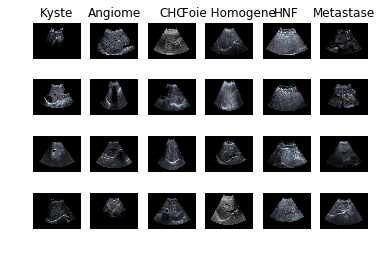

In [6]:
# Visualize a few examples of orig images from each lesion class
num_classes = len(dict_lesion)
samples_per_class = 4
for y, cls in enumerate(dict_lesion):
    idxs = np.flatnonzero(y_class_orig == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        xx = X_orig[idx,:,:,:]
        xx -= np.min(xx)
        xx /= np.max(xx)
        plt.imshow(xx)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Generate train and test set from orig
n = X_orig.shape[0]
test_size = n//9
print('Split: {} testing and {} training samples'.format(test_size, n - test_size))
perm = np.random.permutation(n)
X_test_orig  = X_orig[perm[:test_size]]
X_train_orig = X_orig[perm[test_size:]]
y_test_orig  = y_all_orig[perm[:test_size]]
y_train_orig = y_all_orig[perm[test_size:]]

Split: 40 testing and 327 training samples


In [8]:
# Data pre-processing: centered and reduced
n = X_train_orig.shape[0]
train_data = np.zeros([n,720*960])
for i in range(n):
    xx = X_train_orig[i,:,:,:]
    xx = np.linalg.norm(xx,axis=2)
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    train_data[i] = np.reshape(xx,[-1])

n = X_test_orig.shape[0]
test_data = np.zeros([n,720*960])
for i in range(n):
    xx = X_test_orig[i,:,:,:]
    xx = np.linalg.norm(xx,axis=2)
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    test_data[i] = np.reshape(xx,[-1])

print("Train data shape: {}".format(train_data.shape))
print("Test data shape: {}".format(test_data.shape))

Train data shape: (327, 691200)
Test data shape: (40, 691200)


In [9]:
# Convert label values to one_hot vector
from scipy.sparse import coo_matrix
def convert_to_one_hot(a,max_val=None):
    N = a.size
    data = np.ones(N,dtype=int)
    sparse_out = coo_matrix((data,(np.arange(N),a.ravel())), shape=(N,max_val))
    return np.array(sparse_out.todense())

train_labels = np.concatenate([y_train_orig[:,:2], convert_to_one_hot(y_train_orig[:,2],6)], axis=1)
test_labels = np.concatenate([y_test_orig[:,:2], convert_to_one_hot(y_test_orig[:,2],6)], axis=1)
print("Train label shape: {}".format(train_labels.shape))
print("Test label shape: {}".format(test_labels.shape))

Train label shape: (327, 8)
Test label shape: (40, 8)


# Save numpy arrays

In [10]:
path_to_save = "C:/Users/vince/Documents/DataChallengeJFR/liver/pre_processed/"

np.save(path_to_save + "train_data.npy", train_data)
np.save(path_to_save + "test_data.npy", test_data)
np.save(path_to_save + "train_labels.npy", train_labels)
np.save(path_to_save + "test_labels.npy", test_labels)